# DC Public Schools Student Assessment Results Analysis

## 5/2/2019

### Hiro Miyake

# Introduction  
The DC government shares hundreds of data sets at http://opendata.dc.gov/. I explored one particular data set there, the "DC Public Schools Student Assessment Results" data set.

From the data source website:  
*"This data contains the official 2016-2017 assessment performance results for the Partnership for Assessment of Readiness for College (PARCC) and Multi-State Alternate Assessment (MSAA) assessments in ELA and mathematics. This also includes historical performance information from the 2015-16 and 2014-15 PARCC and MSAA administrations. The dataset contains detailed information, showing multiple levels of results for specific groups of students, for all grades within a school, and for individual grades. For more information, visit https://osse.dc.gov/assessments."*

In this notebook, I explore the factors affecting student assessment results which could be useful for the school board in deciding how best to improve the results for all students.

### Data source  
http://opendata.dc.gov/datasets/dc-public-schools-student-assessment-results

### Other references  
https://osse.dc.gov/assessments  
http://results.osse.dc.gov  
https://osse.dc.gov/parcc  
https://sboe.dc.gov/page/key-terms-know-dc-public-education-enrollment

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import statsmodels.formula.api as smf
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt

# Loading the data and exploratory data analysis

Let's load the data and try to understand what is in it.

In [2]:
df = pd.read_csv('DC_Public_Schools_Student_Assessment_Results.csv')

In [3]:
# Alternatively, you can download csv data directly into a pandas dataframe
#url = 'https://opendata.arcgis.com/datasets/85fce54dea6946dea827c02a6bda88bb_23.csv'
#df = pd.read_csv(url)

In [4]:
df.head()

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,...,SUBGROUP,SUBGROUP_VALUE,PERCENT_MEETING_OR_EXCEEDING_E,PERCENT_LEVEL_3_,PERCENT_LEVEL_1,PERCENT_LEVEL_2,PERCENT_LEVEL_3,PERCENT_LEVEL_4,PERCENT_LEVEL_5,TOTAL_NUMBER_VALID_TEST_TAKERS
0,3029,2014-15,Ward 4,213,Brightwood EC,1,District of Columbia Public Schools,PARCC,ELA,Grade 8,...,Special Programs,At-Risk,n<25,n<25,n<25,n<25,n<25,n<25,n<25,n<25
1,3030,2014-15,Ward 4,213,Brightwood EC,1,District of Columbia Public Schools,PARCC,ELA,Grade 8,...,Special Programs,Economically Disadvantaged,7%,23.3%,44.2%,32.6%,16.3%,7%,0.0%,43
2,3031,2014-15,Ward 4,213,Brightwood EC,1,District of Columbia Public Schools,All,ELA,Grades 3-8,...,All,All,6.4%,26%,NaN,NaN,NaN,NaN,NaN,281
3,3032,2014-15,Ward 4,213,Brightwood EC,1,District of Columbia Public Schools,PARCC,ELA,Grades 3-8,...,All,All,6.4%,26%,47.3%,26.7%,19.6%,6.4%,0.0%,281
4,3033,2014-15,Ward 4,213,Brightwood EC,1,District of Columbia Public Schools,All,Math,Algebra I,...,All,All,n<25,n<25,NaN,NaN,NaN,NaN,NaN,n<25


In [5]:
df.shape

(189364, 21)

Data has 189364 rows and 21 columns.

In [6]:
df.columns

Index([u'OBJECTID', u'SCHOOL_YEAR', u'SCHOOL_WARD', u'SCHOOL_CODE',
       u'SCHOOL_NAME', u'LEA_CODE', u'LEA_NAME', u'ASSESSMENT_TYPE',
       u'SUBJECT', u'TESTED_GRADE_SUBJECT', u'GRADE_OF_ENROLLMENT',
       u'SUBGROUP', u'SUBGROUP_VALUE', u'PERCENT_MEETING_OR_EXCEEDING_E',
       u'PERCENT_LEVEL_3_', u'PERCENT_LEVEL_1', u'PERCENT_LEVEL_2',
       u'PERCENT_LEVEL_3', u'PERCENT_LEVEL_4', u'PERCENT_LEVEL_5',
       u'TOTAL_NUMBER_VALID_TEST_TAKERS'],
      dtype='object')

In [7]:
df.dtypes

OBJECTID                           int64
SCHOOL_YEAR                       object
SCHOOL_WARD                       object
SCHOOL_CODE                        int64
SCHOOL_NAME                       object
LEA_CODE                           int64
LEA_NAME                          object
ASSESSMENT_TYPE                   object
SUBJECT                           object
TESTED_GRADE_SUBJECT              object
GRADE_OF_ENROLLMENT               object
SUBGROUP                          object
SUBGROUP_VALUE                    object
PERCENT_MEETING_OR_EXCEEDING_E    object
PERCENT_LEVEL_3_                  object
PERCENT_LEVEL_1                   object
PERCENT_LEVEL_2                   object
PERCENT_LEVEL_3                   object
PERCENT_LEVEL_4                   object
PERCENT_LEVEL_5                   object
TOTAL_NUMBER_VALID_TEST_TAKERS    object
dtype: object

Let's understand what the various columns contain.

In [8]:
len(df.OBJECTID.unique())

189364

OBJECTID is most likely the unique identifier for each row.

In [9]:
df.SCHOOL_YEAR.value_counts()

2016-17    78701
2015-16    56244
2014-15    54419
Name: SCHOOL_YEAR, dtype: int64

The data set contains 3 school years worth of data. For my analysis I will only look at the most recent school year of 2016-2017.

In [10]:
df.SCHOOL_WARD.value_counts()

Ward 4    37018
Ward 5    34136
Ward 6    29930
Ward 7    22724
Ward 8    20980
Ward 1    18303
Ward 3    13839
Ward 2    12218
Name: SCHOOL_WARD, dtype: int64

There are 8 wards.

In [11]:
len(df.SCHOOL_CODE.unique())

218

In [12]:
len(df.SCHOOL_NAME.unique())

218

Probably a given `SCHOOL_CODE` corresponds to a unique `SCHOOL_NAME`. That makes sense.

LEA stands for "Local Education Agency." (https://osse.dc.gov/parcc) From the DC government website, LEA is  
*"An entity that operates public elementary and secondary schools. DCPS is its own LEA and each charter network is its own LEA. Each LEA creates its own set of policies and helps ensure the on-the-ground implementation of federal and state policies."* (https://sboe.dc.gov/page/key-terms-know-dc-public-education-enrollment)

In [13]:
df.LEA_CODE.value_counts()

1       107956
156       8205
120       7913
129       7505
116       3395
108       3290
115       3182
109       2856
151       2455
149       2142
121       2126
168       2102
143       1916
181       1803
165       1733
135       1696
138       1434
155       1382
125       1332
132       1272
153       1246
160       1136
127       1130
169       1062
114       1018
130        994
144        992
124        966
113        964
142        914
171        894
175        886
179        812
188        808
158        786
170        724
185        640
139        618
117        578
186        554
107        548
167        532
166        492
180        480
140        472
146        336
126        326
152        308
147        300
137        273
163        260
118        260
133        252
184        220
4002       216
174        192
177        168
173        132
122        108
190         72
Name: LEA_CODE, dtype: int64

In [14]:
len(df.LEA_CODE.unique())

60

In [15]:
len(df.LEA_NAME.unique())

60

There are 60 unique LEA codes and names. Probably the LEA codes and names are one-to-one and onto. Let's check this with LEA code 1.

In [16]:
df[df.LEA_CODE == 1].LEA_NAME.value_counts()

District of Columbia Public Schools    107956
Name: LEA_NAME, dtype: int64

Yes, LEA code 1 corresponds to the DC Public School.

So most likely the LEA code collapses all DC Public Schools into a single group and keeps all other school in their own group. So these features are similar to `SCHOOL_CODE` and `SCHOOL_NAME` so we don't need to use both sets of features.

In [17]:
df.ASSESSMENT_TYPE.value_counts()

All      89434
PARCC    87464
MSAA     12466
Name: ASSESSMENT_TYPE, dtype: int64

We have two different assessment types: PARCC and MSAA. PARCC stands for "Partnership for Assessment of Readiness for College and Careers" and MSAA stands for "Multi-State Alternate Assessment."

We know that MSAA is scored from 1 to 4, and PARCC is scored from 1 to 5 (http://results.osse.dc.gov/glossary). Let's make sure there are no values in `PERCENT_LEVEL_5` for MSAA.

In [18]:
df[df.ASSESSMENT_TYPE == 'MSAA'].PERCENT_LEVEL_5.head()

650    NaN
651    NaN
652    NaN
861    NaN
862    NaN
Name: PERCENT_LEVEL_5, dtype: object

In [19]:
df[df.ASSESSMENT_TYPE == 'MSAA'].PERCENT_LEVEL_5.value_counts(dropna=False)

NaN    12466
Name: PERCENT_LEVEL_5, dtype: int64

Indeed there is no value for `PERCENT_LEVEL_5` for MSAA.

In [20]:
df.SUBJECT.value_counts()

Math    105643
ELA      83721
Name: SUBJECT, dtype: int64

There are only two subjects. ELA stands for 'English Language Arts' (https://osse.dc.gov/parcc).

In [21]:
df.TESTED_GRADE_SUBJECT.value_counts()

All             53290
Grade 3         22223
Grade 4         21222
Grade 5         20939
Grades 3-8      18064
Grade 6         13091
Grade 7         12492
Grade 8         11570
Grades 9-12      4203
Geometry         3964
Algebra I        3564
English II       3358
Grade 11          920
Algebra II        252
Integrated M      188
English I          24
Name: TESTED_GRADE_SUBJECT, dtype: int64

If we want to understand the effect of `TESTED_GRADE_SUBJECT` on the outcome, I should remove the `All` values.

In [22]:
df.GRADE_OF_ENROLLMENT.value_counts()

All        169940
Grade 8     10369
Grade 7      9055
Name: GRADE_OF_ENROLLMENT, dtype: int64

I don't care about the grade of enrollment, so I should subset the `All` rows. Plus, it seems strange that only grades 7 and 8 are present. Given that many other grades are present in the `TESTED_GRADE_SUBJECT`, there should really be more values present.

In [23]:
df.SUBGROUP.value_counts()

Race by Gender      62351
Special Programs    48142
Race/Ethnicity      36903
Gender              26330
All                 15638
Name: SUBGROUP, dtype: int64

We see that there are 5 different subgroups. I would really like to have a breakdown by race, gender and special programs simultaneously so that I can account for all of them, but unfortunately the data is only provided in these slices. So for modeling, I can only choose one of the options.

In [24]:
df.SUBGROUP_VALUE.value_counts()

All                                        15638
Economically Disadvantaged                 13576
Black/African American                     13514
Male                                       13250
Active or Monitored Special Education      13174
At-Risk                                    13107
Female                                     13080
Male-Black/African American                13067
Female-Black/African American              12845
Hispanic/Latino                             9395
Active or Monitored English Learner         8285
Male-Hispanic/Latino                        8117
Female-Hispanic/Latino                      7758
White/Caucasian                             4568
Two or More Races                           4348
Male-White/Caucasian                        3731
Female-White/Caucasian                      3494
Asian                                       3418
Female-Two or More Races                    3264
Male-Two or More Races                      3204
Male-Asian          

There are many subgroup values, probably corresponding to the different subgroups.

In [25]:
df[df.SUBGROUP == 'Race by Gender'].SUBGROUP_VALUE.value_counts()

Male-Black/African American                13067
Female-Black/African American              12845
Male-Hispanic/Latino                        8117
Female-Hispanic/Latino                      7758
Male-White/Caucasian                        3731
Female-White/Caucasian                      3494
Female-Two or More Races                    3264
Male-Two or More Races                      3204
Male-Asian                                  2601
Female-Asian                                2398
Female-Pacific Islander/Native Hawaiian      498
Male-Pacific Islander/Native Hawaiian        488
Female-American Indian/Alaskan Native        444
Male-American Indian/Alaskan Native          442
Name: SUBGROUP_VALUE, dtype: int64

In [26]:
df[df.SUBGROUP == 'Special Programs'].SUBGROUP_VALUE.value_counts()

Economically Disadvantaged               13576
Active or Monitored Special Education    13174
At-Risk                                  13107
Active or Monitored English Learner       8285
Name: SUBGROUP_VALUE, dtype: int64

In [27]:
df[df.SUBGROUP == 'Race/Ethnicity'].SUBGROUP_VALUE.value_counts()

Black/African American              13514
Hispanic/Latino                      9395
White/Caucasian                      4568
Two or More Races                    4348
Asian                                3418
Pacific Islander/Native Hawaiian      858
American Indian/Alaskan Native        802
Name: SUBGROUP_VALUE, dtype: int64

In [28]:
df[df.SUBGROUP == 'Gender'].SUBGROUP_VALUE.value_counts()

Male      13250
Female    13080
Name: SUBGROUP_VALUE, dtype: int64

In [29]:
df[df.SUBGROUP == 'All'].SUBGROUP_VALUE.value_counts()

All    15638
Name: SUBGROUP_VALUE, dtype: int64

All these values seem to make sense.

# Feature selection and engineering

Now that we have some understanding of the raw data, let's do some feature selection and engineering.

Let's recall the columns in the data set.

In [30]:
df.columns

Index([u'OBJECTID', u'SCHOOL_YEAR', u'SCHOOL_WARD', u'SCHOOL_CODE',
       u'SCHOOL_NAME', u'LEA_CODE', u'LEA_NAME', u'ASSESSMENT_TYPE',
       u'SUBJECT', u'TESTED_GRADE_SUBJECT', u'GRADE_OF_ENROLLMENT',
       u'SUBGROUP', u'SUBGROUP_VALUE', u'PERCENT_MEETING_OR_EXCEEDING_E',
       u'PERCENT_LEVEL_3_', u'PERCENT_LEVEL_1', u'PERCENT_LEVEL_2',
       u'PERCENT_LEVEL_3', u'PERCENT_LEVEL_4', u'PERCENT_LEVEL_5',
       u'TOTAL_NUMBER_VALID_TEST_TAKERS'],
      dtype='object')

Just select the most recent school year.

In [31]:
df_feat = df[df.SCHOOL_YEAR == '2016-17']

If we want to take the average score and predict based on that, we should just use data from either PARCC or MSAA, not both. Since there appear to be more data for PARCC, let's subset that.

In [32]:
df_feat = df_feat[df_feat.ASSESSMENT_TYPE != 'MSAA']

The percentage levels represent the fraction of students in that group that scored in a particular range. The levels are given as follows.

PARCC performance levels:  
* Level 1: Did not yet meet expectations
* Level 2: Partially met expectations
* Level 3: Approached expectations
* Level 4: Met expectations
* Level 5: Exceeded expectations

MSAA performance levels:  
* Level 1: Did not yet meet expectations
* Level 2: Partially met expectations
* Level 3: Met expectations
* Level 4: Exceeded expectations

Levels 4 and above are considered to be meeting or exceeding expectations.

Let's drop all rows that have any NaNs. The NaNs exist in the percentage columns. 

In [33]:
df_feat = df_feat.dropna()

In [34]:
df_feat.head()

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,...,SUBGROUP,SUBGROUP_VALUE,PERCENT_MEETING_OR_EXCEEDING_E,PERCENT_LEVEL_3_,PERCENT_LEVEL_1,PERCENT_LEVEL_2,PERCENT_LEVEL_3,PERCENT_LEVEL_4,PERCENT_LEVEL_5,TOTAL_NUMBER_VALID_TEST_TAKERS
104000,105405,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,Special Programs,At-Risk,9.8%,34.1%,48.8%,17.1%,24.4%,9.8%,0.0%,41
104001,105406,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,Special Programs,Economically Disadvantaged,9.9%,40.8%,39.4%,19.7%,31.0%,9.9%,0.0%,71
104386,105728,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,Race/Ethnicity,Two or More Races,n<25,n<25,n<25,n<25,n<25,n<25,n<25,n<25
104387,105729,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,Race/Ethnicity,White/Caucasian,n<25,n<25,n<25,n<25,n<25,n<25,n<25,n<25
104388,105730,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,Special Programs,Active or Monitored Special Education,n<25,n<25,n<25,n<25,n<25,n<25,n<25,n<25


We should also drop rows that have "n<25" since we can't quantitatively do much with that. This is so that individual students cannot be identified in that subset. (http://results.osse.dc.gov/glossary)

In [35]:
df_feat = df_feat[df_feat.TOTAL_NUMBER_VALID_TEST_TAKERS != 'n<25']

In [36]:
df_feat.head()

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,...,SUBGROUP,SUBGROUP_VALUE,PERCENT_MEETING_OR_EXCEEDING_E,PERCENT_LEVEL_3_,PERCENT_LEVEL_1,PERCENT_LEVEL_2,PERCENT_LEVEL_3,PERCENT_LEVEL_4,PERCENT_LEVEL_5,TOTAL_NUMBER_VALID_TEST_TAKERS
104000,105405,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,Special Programs,At-Risk,9.8%,34.1%,48.8%,17.1%,24.4%,9.8%,0.0%,41
104001,105406,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,Special Programs,Economically Disadvantaged,9.9%,40.8%,39.4%,19.7%,31.0%,9.9%,0.0%,71
104655,105865,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,Special Programs,At-Risk,9.8%,34.1%,48.8%,17.1%,24.4%,9.8%,0.0%,41
104656,105866,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,Special Programs,Economically Disadvantaged,9.9%,40.8%,39.4%,19.7%,31.0%,9.9%,0.0%,71
104715,105880,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,...,All,All,9.9%,40.8%,39.4%,19.7%,31.0%,9.9%,0.0%,71


In [37]:
df_feat.shape

(14069, 21)

It looks like `PERCENT_LEVEL_3_` is the total percentage scoring at level 3 and above. `PERCENTAGE_MEETING_OR_EXCEEDING_E` is the total percentage scoring at level 4 and above.

We need to convert the percent level values to numbers. So we need to strip the percent sign. Let's make sure all the rows have the same format with a percent sign as the last character.

In [38]:
print sum(df_feat.PERCENT_MEETING_OR_EXCEEDING_E.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_3_.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_1.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_2.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_3.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_4.map(lambda x: x[-1] == '%'))
print sum(df_feat.PERCENT_LEVEL_5.map(lambda x: x[-1] == '%'))

14069
14069
14069
14069
14069
14069
14069


It looks like all rows have values with a percent sign at the end. So let's get rid of this and convert to a float.

In [39]:
df_feat['passed_percentage'] = df_feat.PERCENT_MEETING_OR_EXCEEDING_E.map(lambda x: float(x[:-1]))
df_feat['above_3'] = df_feat.PERCENT_LEVEL_3_.map(lambda x: float(x[:-1]))
df_feat['level_1'] = df_feat.PERCENT_LEVEL_1.map(lambda x: float(x[:-1]))
df_feat['level_2'] = df_feat.PERCENT_LEVEL_2.map(lambda x: float(x[:-1]))
df_feat['level_3'] = df_feat.PERCENT_LEVEL_3.map(lambda x: float(x[:-1]))
df_feat['level_4'] = df_feat.PERCENT_LEVEL_4.map(lambda x: float(x[:-1]))
df_feat['level_5'] = df_feat.PERCENT_LEVEL_5.map(lambda x: float(x[:-1]))

Let's make sure all of the level rows sum to close to 100.

In [40]:
df_feat['total_percentage'] = df_feat.level_1+df_feat.level_2+df_feat.level_3+df_feat.level_4+df_feat.level_5

In [41]:
len(df_feat[abs(df_feat.total_percentage - 100) > 5])

0

At least none of the sums deviate from a 100 by more than 5.

In [42]:
df_feat.total_percentage.value_counts()

100.0    6825
99.9     1549
100.1    1538
99.9     1112
100.0    1009
100.0     911
100.1     878
100.1      69
99.9       43
100.2      32
99.9       28
100.1      24
99.8       21
100.2      16
99.8        7
99.8        4
100.2       2
100.0       1
Name: total_percentage, dtype: int64

It looks like the largest deviation is by about 0.2 percent, which is a reasonable rounding error. So the level percentages make sense.

Let's also create binary variables for the rows where there were some students that received a level of 4 or 5, a level of 3 and above, and a level of 5.

In [43]:
df_feat['passed_binary'] = df_feat.passed_percentage.map(lambda x: 0 if x == 0 else 1)
df_feat['above_3_binary'] = df_feat.above_3.map(lambda x: 0 if x == 0 else 1)
df_feat['above_5_binary'] = df_feat.level_5.map(lambda x: 0 if x == 0 else 1)

In [44]:
df_feat.passed_binary.value_counts()

1    13219
0      850
Name: passed_binary, dtype: int64

In [45]:
df_feat.above_3_binary.value_counts()

1    13926
0      143
Name: above_3_binary, dtype: int64

In [46]:
df_feat.above_5_binary.value_counts()

0    7436
1    6633
Name: above_5_binary, dtype: int64

More rows are at or above level 3 than at or above level 4. This makes sense. Also if we binarize based on whether any of the students were at level 5, we get about equal numbers in the two classes and so could apply logistic regression. But we are probably losing information if we bunch everybody from 1 to 4 in a single group and are using information more efficiently by looking at the average score, which is a continuous variable.

In [47]:
df_feat['average_level'] = 1.0/100.0*(df_feat.level_1*1.0 + df_feat.level_2*2.0 + df_feat.level_3*3.0 + df_feat.level_4*4.0 + df_feat.level_5*5.0)

In [48]:
df_feat.average_level.head()

104000    1.954
104001    2.114
104655    1.954
104656    2.114
104715    2.114
Name: average_level, dtype: float64

I will get rid of SUBGROUPs that are 'All' since these don't have a lot of characteristics.

In [49]:
df_feat = df_feat[df_feat.SUBGROUP != 'All']

In [50]:
df_feat.head()

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,...,level_1,level_2,level_3,level_4,level_5,total_percentage,passed_binary,above_3_binary,above_5_binary,average_level
104000,105405,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,48.8,17.1,24.4,9.8,0.0,100.1,1,1,0,1.954
104001,105406,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,39.4,19.7,31.0,9.9,0.0,100.0,1,1,0,2.114
104655,105865,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,48.8,17.1,24.4,9.8,0.0,100.1,1,1,0,1.954
104656,105866,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,All,...,39.4,19.7,31.0,9.9,0.0,100.0,1,1,0,2.114
104716,105881,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,...,29.6,33.3,18.5,18.5,0.0,99.9,1,1,0,2.257


In [51]:
df_feat.GRADE_OF_ENROLLMENT.value_counts()

All        10877
Grade 7      582
Grade 8      551
Name: GRADE_OF_ENROLLMENT, dtype: int64

I should subset on all, since I don't care what grade they are in.

In [52]:
df_feat = df_feat[df_feat.GRADE_OF_ENROLLMENT == 'All']
df_feat = df_feat[df_feat.TESTED_GRADE_SUBJECT != 'All']

In [53]:
df_feat.iloc[:5,:15]

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,GRADE_OF_ENROLLMENT,SUBGROUP,SUBGROUP_VALUE,PERCENT_MEETING_OR_EXCEEDING_E,PERCENT_LEVEL_3_
104000,105405,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,All,Special Programs,At-Risk,9.8%,34.1%
104001,105406,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,All,Special Programs,Economically Disadvantaged,9.9%,40.8%
104716,105881,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,All,Gender,Female,18.5%,37.0%
104717,105882,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,All,Gender,Male,4.5%,43.2%
104718,105883,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,All,Race by Gender,Female-Black/African American,15.4%,34.6%


In [54]:
df_feat.iloc[:5,15:]

,PERCENT_LEVEL_1,PERCENT_LEVEL_2,PERCENT_LEVEL_3,PERCENT_LEVEL_4,PERCENT_LEVEL_5,TOTAL_NUMBER_VALID_TEST_TAKERS,passed_percentage,above_3,level_1,level_2,level_3,level_4,level_5,total_percentage,passed_binary,above_3_binary,above_5_binary,average_level
104000,48.8%,17.1%,24.4%,9.8%,0.0%,41,9.8,34.1,48.8,17.1,24.4,9.8,0.0,100.1,1,1,0,1.954
104001,39.4%,19.7%,31.0%,9.9%,0.0%,71,9.9,40.8,39.4,19.7,31.0,9.9,0.0,100.0,1,1,0,2.114
104716,29.6%,33.3%,18.5%,18.5%,0.0%,27,18.5,37.0,29.6,33.3,18.5,18.5,0.0,99.9,1,1,0,2.257
104717,45.5%,11.4%,38.6%,4.5%,0.0%,44,4.5,43.2,45.5,11.4,38.6,4.5,0.0,100.0,1,1,0,2.021
104718,30.8%,34.6%,19.2%,15.4%,0.0%,26,15.4,34.6,30.8,34.6,19.2,15.4,0.0,100.0,1,1,0,2.192


In [55]:
df_feat.SUBGROUP.value_counts()

Special Programs    2587
Gender              1893
Race by Gender      1719
Race/Ethnicity      1561
Name: SUBGROUP, dtype: int64

Let's look at race and ethnicity.

In [56]:
#df_race = df_feat[df_feat.SUBGROUP == 'Race by Gender']
df_race = df_feat[df_feat.SUBGROUP == 'Race/Ethnicity']

In [57]:
df_race.shape

(1561, 33)

In [58]:
df_race.head()

,OBJECTID,SCHOOL_YEAR,SCHOOL_WARD,SCHOOL_CODE,SCHOOL_NAME,LEA_CODE,LEA_NAME,ASSESSMENT_TYPE,SUBJECT,TESTED_GRADE_SUBJECT,...,level_1,level_2,level_3,level_4,level_5,total_percentage,passed_binary,above_3_binary,above_5_binary,average_level
104722,105887,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grade 3,...,39.1,20.3,31.9,8.7,0.0,100.0,1,1,0,2.102
104996,105401,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,ELA,Grades 3-8,...,39.1,20.3,31.9,8.7,0.0,100.0,1,1,0,2.102
105728,106523,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,Math,Grade 3,...,24.6,23.2,33.3,17.4,1.4,99.9,1,1,1,2.475
105754,106549,2016-17,Ward 8,217,Achievement Preparatory Academy PCS Wahler Pla...,155,Achievement Preparatory Academy PCS,PARCC,Math,Grades 3-8,...,24.6,23.2,33.3,17.4,1.4,99.9,1,1,1,2.475
109221,110832,2016-17,Ward 4,205,Barnard ES,1,District of Columbia Public Schools,PARCC,ELA,Grade 3,...,18.4,23.7,26.3,31.6,0.0,100.0,1,1,0,2.711


In [59]:
df_race.SUBGROUP_VALUE.value_counts()

Black/African American    1119
Hispanic/Latino            271
White/Caucasian            151
Two or More Races           14
Asian                        6
Name: SUBGROUP_VALUE, dtype: int64

There are only 6 rows with Asian, and 14 with Two or More Races. We should get rid of these since this is not a lot of data for modeling these categories.

In [60]:
df_race = df_race[(df_race.SUBGROUP_VALUE != 'Asian') & (df_race.SUBGROUP_VALUE != 'Two or More Races')]

In [61]:
df_race.SUBGROUP_VALUE.value_counts()

Black/African American    1119
Hispanic/Latino            271
White/Caucasian            151
Name: SUBGROUP_VALUE, dtype: int64

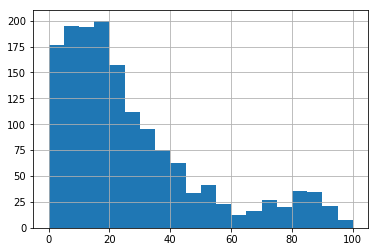

In [62]:
df_race.passed_percentage.hist(bins = 20)

Let's see how many, if any, have zero passing.

In [63]:
print df_race[df_race.passed_percentage == 0.0].shape
print df_race[df_race.passed_percentage > 0.0].shape

(55, 33)
(1486, 33)


Some of them do have zero students passing, but it is not that much to make a binary prediction very robust.

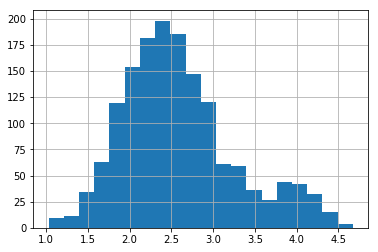

In [64]:
df_race.average_level.hist(bins = 20)

If you look at the average level the distribution is looking reasonable. I will build a model that predicts the average level for a given row and look at the features that determine the average level.

# Modeling

Let's remind ourselves what the features are.

In [65]:
df_race.columns

Index([u'OBJECTID', u'SCHOOL_YEAR', u'SCHOOL_WARD', u'SCHOOL_CODE',
       u'SCHOOL_NAME', u'LEA_CODE', u'LEA_NAME', u'ASSESSMENT_TYPE',
       u'SUBJECT', u'TESTED_GRADE_SUBJECT', u'GRADE_OF_ENROLLMENT',
       u'SUBGROUP', u'SUBGROUP_VALUE', u'PERCENT_MEETING_OR_EXCEEDING_E',
       u'PERCENT_LEVEL_3_', u'PERCENT_LEVEL_1', u'PERCENT_LEVEL_2',
       u'PERCENT_LEVEL_3', u'PERCENT_LEVEL_4', u'PERCENT_LEVEL_5',
       u'TOTAL_NUMBER_VALID_TEST_TAKERS', u'passed_percentage', u'above_3',
       u'level_1', u'level_2', u'level_3', u'level_4', u'level_5',
       u'total_percentage', u'passed_binary', u'above_3_binary',
       u'above_5_binary', u'average_level'],
      dtype='object')

I could include the school code/name or LEA code/name, but given there are only about 1500 rows and not a lot of granularity in the data, including these could lead to overfitting. I can rigorously test this by cross-validation for example, but for now I decide to not include these in the model.

In [66]:
df_race_model = df_race[['SCHOOL_WARD','SUBJECT','TESTED_GRADE_SUBJECT','SUBGROUP_VALUE','average_level']]
#df_race_model = df_race[['SCHOOL_WARD','LEA_NAME','SUBJECT','TESTED_GRADE_SUBJECT','SUBGROUP_VALUE','average_level']]

In [67]:
df_race_model.head()

,SCHOOL_WARD,SUBJECT,TESTED_GRADE_SUBJECT,SUBGROUP_VALUE,average_level
104722,Ward 8,ELA,Grade 3,Black/African American,2.102
104996,Ward 8,ELA,Grades 3-8,Black/African American,2.102
105728,Ward 8,Math,Grade 3,Black/African American,2.475
105754,Ward 8,Math,Grades 3-8,Black/African American,2.475
109221,Ward 4,ELA,Grade 3,Black/African American,2.711


Let's check and make sure all of the column values are distributed reasonably.

In [68]:
df_race_model.SCHOOL_WARD.value_counts()

Ward 4    262
Ward 5    238
Ward 8    237
Ward 7    214
Ward 6    205
Ward 1    182
Ward 3    121
Ward 2     82
Name: SCHOOL_WARD, dtype: int64

In [69]:
df_race_model.SUBJECT.value_counts()

Math    774
ELA     767
Name: SUBJECT, dtype: int64

In [70]:
df_race_model.TESTED_GRADE_SUBJECT.value_counts()

Grades 3-8      442
Grade 3         197
Grade 4         191
Grade 5         172
Grade 6         126
Grade 7         112
Grade 8         102
Grades 9-12      97
Geometry         47
English II       46
Algebra I         5
Integrated M      2
Algebra II        2
Name: TESTED_GRADE_SUBJECT, dtype: int64

In [71]:
df_race_model.SUBGROUP_VALUE.value_counts()

Black/African American    1119
Hispanic/Latino            271
White/Caucasian            151
Name: SUBGROUP_VALUE, dtype: int64

There are some low value categories, but overall it looks reasonable to perform a linear regression.

In [72]:
# https://www.statsmodels.org/stable/index.html
# https://www.statsmodels.org/devel/examples/notebooks/generated/ols.html
race_formula = 'average_level ~ SCHOOL_WARD'
for i, col in enumerate(df_race_model):
    if col != 'average_level' and col != 'SCHOOL_WARD':
        race_formula = race_formula + ' + ' + col
print race_formula

average_level ~ SCHOOL_WARD + SUBJECT + TESTED_GRADE_SUBJECT + SUBGROUP_VALUE


In [73]:
#race_results = smf.logit(race_formula, data=df_race_model).fit(method='bfgs', maxiter=100)
race_results = smf.ols(race_formula, data=df_race_model).fit()
race_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          average_level   R-squared:                       0.568
Model:                            OLS   Adj. R-squared:                  0.562
Method:                 Least Squares   F-statistic:                     90.68
Date:                Thu, 02 May 2019   Prob (F-statistic):          1.76e-257
Time:                        00:19:53   Log-Likelihood:                -942.07
No. Observations:                1541   AIC:                             1930.
Df Residuals:                    1518   BIC:                             2053.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                2.2896      0.205     11.158      0.000       1.887       2.692
SCHOOL_WARD[T.Ward 2]                    0.3256      0.062      5.231      0.000       0.204       0.448
SCHOOL_WARD[T.Ward 3]                    0.4076      0.058      7.058      0.000       0.294       0.521
SCHOOL_WARD[T.Ward 4]                    0.0418      0.044      0.957      0.339      -0.044       0.128
SCHOOL_WARD[T.Ward 5]                   -0.1219      0.048     -2.563      0.010      -0.215      -0.029
SCHOOL_WARD[T.Ward 6]                   -0.0563      0.049     -1.144      0.253      -0.153       0.040
SCHOOL_WARD[T.Ward 7]                   -0.2049      0.050     -4.130      0.000      -0.302      -0.108
SCHOOL_WARD[T.Ward 8]                   -0.3874      0.049     -7.959      0.000      -0.483      -0.292
SUBJECT[T.Math]                         -0.0135      0.024     -0.568      0.570      -0.060       0.033
TESTED_GRADE_SUBJECT[T.Algebra II]      -0.3463      0.378     -0.916      0.360      -1.088       0.395
TESTED_GRADE_SUBJECT[T.English II]       0.0469      0.214      0.220      0.826      -0.372       0.466
TESTED_GRADE_SUBJECT[T.Geometry]        -0.0517      0.212     -0.244      0.808      -0.468       0.364
TESTED_GRADE_SUBJECT[T.Grade 3]          0.2705      0.205      1.321      0.187      -0.131       0.672
TESTED_GRADE_SUBJECT[T.Grade 4]          0.3304      0.205      1.613      0.107      -0.071       0.732
TESTED_GRADE_SUBJECT[T.Grade 5]          0.3551      0.205      1.731      0.084      -0.047       0.757
TESTED_GRADE_SUBJECT[T.Grade 6]          0.1882      0.206      0.913      0.361      -0.216       0.592
TESTED_GRADE_SUBJECT[T.Grade 7]          0.2406      0.207      1.165      0.244      -0.165       0.646
TESTED_GRADE_SUBJECT[T.Grade 8]          0.0932      0.207      0.450      0.653      -0.313       0.499
TESTED_GRADE_SUBJECT[T.Grades 3-8]       0.3048      0.203      1.499      0.134      -0.094       0.704
TESTED_GRADE_SUBJECT[T.Grades 9-12]      0.0052      0.207      0.025      0.980      -0.401       0.412
TESTED_GRADE_SUBJECT[T.Integrated M]     0.3353      0.378      0.887      0.375      -0.406       1.077
SUBGROUP_VALUE[T.Hispanic/Latino]        0.0357      0.037      0.971      0.332      -0.036       0.108
SUBGROUP_VALUE[T.White/Caucasian]        1.2345      0.046     26.588      0.000       1.143       1.326
==============================================================================
Omnibus:                       57.059   Durbin-Watson:                   1.464
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               72.907
Skew:                           0.394   Prob(JB):                     1.47e-16
Kurtosis:                       3.717

In [74]:
race_pred = race_results.predict(df_race_model) # Predict probability
race_score = r2_score(df_race_model['average_level'], race_pred)
#print 'Area under the ROC curve: ' + str(twitter_score)
print 'Score for the training set: ' + str(race_score)

Score for the training set: 0.5678797600826108


The R squared value is 0.57, which means 57% of the data is explained by the model.

Now I want to know which features are most predictive of the average level. More positive the coefficient, the more positively it affects the outcome, and more negative the coefficient, the more negatively it affects the outcome. I also only want to consider statistically significant features, so I only consider those features with p-values less than $0.05/N$, where $N$ is the total number of features in the model. This is the Bonferroni correction, and is conservative but a quick way to deal with cases when you have many features, since by chance some may appear statistically significant.

In [75]:
race_params = pd.DataFrame([race_results.params, race_results.pvalues], index = ['params','pvalues'])
race_params = race_params.transpose()
race_params[race_params.pvalues < 0.05/(df_race_model.shape[1] - 1)].sort_values(by = ['params'])

,params,pvalues
SCHOOL_WARD[T.Ward 8],-0.387426,3.377372e-15
SCHOOL_WARD[T.Ward 7],-0.204938,3.830926e-05
SCHOOL_WARD[T.Ward 5],-0.121866,1.048703e-02
SCHOOL_WARD[T.Ward 2],0.325594,1.918392e-07
SCHOOL_WARD[T.Ward 3],0.407632,2.557064e-12
SUBGROUP_VALUE[T.White/Caucasian],1.234476,3.387583e-128
Intercept,2.289633,7.667785e-28


The test subject is not predictive of whether a group passes. This makes sense, because each subject should be calibrated so that roughly the same fraction of students achieve the same level across all subjects.

Race is predictive. In this case, the baseline is the `Black/African American` category. Being `White/Caucasian` increases the average level by 1.23, all else being constant. Relative to the baseline, `Hispanic/Latino` has no effect.

Ward is generally predictive of average level. Below is a map of the different wards of DC.

Ward image from https://planning.dc.gov/page/neighborhood-planning-01.

![title](wards_small.png)

Wards 8, 7, and 5 are generally the lower median income areas, and Wards 2 and 3 are the higher median income areas. (http://dceconomicstrategy.com/household-income/) So Ward is most likely a proxy for the economic well-being of the school and possibly for the students as well.

# Recommendations

From the model, I can conclude that it would be beneficial to find a way to help African American students as well as Hispanic students, perhaps by engaging the parents and the local communities to foster an environment of encouraging academic excellence. Independent of race, schools located in different Wards perform differently. In particular, schools located in Wards with lower median income tend to perform worse on the tests, so the school system can perhaps look at ways to redistribute funding in a way so that the schools in the Wards with lower test scores can have the necessary funds for upkeep and maintenance as well as to attract the best and brightest teachers and fund school activities that would enrich the students lives.

Note that my model does not distinguish between individual schools. I did not take this into account since the data did not contain sufficient granularity to definitively prevent overfitting. If I had individual student level data, then a prediction model including the individual schools could reveal particular schools that are performing better or worse, independent of all of the other factors.